In [1]:
# pip install opencv-python

In [111]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.9.1
numpy:       1.23.2
matplotlib:  3.5.3
sklearn:     1.1.2


In [112]:
modelname   = 'base'

IMG_SIZE = 180 # Specify height and width of image to match the input format of the model
IMG_WIDTH = IMG_SIZE
IMG_HEIGHT = IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 64 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
EPOCHS = 40
OPT_IDX = 1
ACTIVATION = 'softmax'

class_names = ''
modelname = modelname+"_"+str(IMG_SIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001)]
optmz = optmzs[OPT_IDX]

In [113]:
def readImagesFromDir(base_img_path='dataset/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.')]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_image(image_string, channels=CHANNELS, expand_animations = False)
    #if (filename.lower().endswith(('.jpg', '.jpeg'))):
    #    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    #if (filename.lower().endswith(('.png'))):
    #    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH])
    
    image_cropped = tf.image.random_crop(image_resized, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    image_rotated = tf.image.rot90(image_cropped, k=3)
    image_flip = tf.image.flip_left_right(image_rotated)
    
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_flip / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


def predict_new_image(img_file):    
    img = tf.keras.utils.load_img(
        img_file, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    #img_array = np.array([img_array])

    saved_model = load_model(model_file)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    #score = tf.sigmoid(predictions[0])
    #score = tf.nn.sigmoid_cross_entropy_with_logits(labels=class_names, logits=predictions[0])
    #score = tf.math.sigmoid(predictions[0])
    #score = tf.tanh(predictions[0])

    #model.evaluate(img_array)

    print(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [114]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['oranda', 'luohan', 'arrowana', 'betta_fish', 'common_goldfish']
0. arrowana
1. betta_fish
2. common_goldfish
3. luohan
4. oranda
(6463, 5)
(1616, 5)


In [115]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

dataset/luohan/240_F_491469333_0yjOsxSoDk6zKsVKfOG6CiuwMva8paSX.jpg [0 0 0 1 0]
dataset/oranda/frame26070.jpg [0 0 0 0 1]
dataset/oranda/frame41090.jpg [0 0 0 0 1]
dataset/oranda/frame33120.jpg [0 0 0 0 1]
dataset/betta_fish/betta0535.jpg [0 1 0 0 0]
dataset/arrowana/240_F_237634033_wXtqg323lBKVZrx0zxwyZdoW9lyBWuoJ.jpg [1 0 0 0 0]
dataset/oranda/frame36010.jpg [0 0 0 0 1]
dataset/betta_fish/betta0585.jpg [0 1 0 0 0]
dataset/oranda/frame27270.jpg [0 0 0 0 1]
dataset/oranda/frame37920.jpg [0 0 0 0 1]


In [116]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
for f, l in val_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (64, 180, 180, 3)
Shape of labels array: (64, 5)
Shape of features array: (64, 180, 180, 3)
Shape of labels array: (64, 5)


In [117]:
def createModel():
    model = Sequential()
    model.add(Conv2D(64, (5,5), padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(N_LABELS, activation=ACTIVATION))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 180, 180, 64)      4864      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 90, 90, 32)        18464     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 22, 22, 32)     

In [118]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/base_180_40_64_1_2022-09-19_01-54-16.hdf5
Path to log:   models/base_180_40_64_1_2022-09-19_01-54-16.csv


In [119]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/base_180_40_64_1_2022-09-19_01-54-16_plot.png


In [120]:
history = model.fit(train_ds,                            # Training data and label
          validation_data=val_ds,   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/40
 15/101 [===>..........................] - ETA: 3s - loss: 1.4619 - accuracy: 0.4094

2022-09-19 01:54:27.639532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 6s 46ms/step - loss: 1.2210 - accuracy: 0.4595 - val_loss: 1.0175 - val_accuracy: 0.5433
Epoch 2/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.9564 - accuracy: 0.5031

2022-09-19 01:54:32.612735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 5s 45ms/step - loss: 0.9069 - accuracy: 0.5208 - val_loss: 0.8332 - val_accuracy: 0.5625
Epoch 3/40
 16/101 [===>..........................] - ETA: 3s - loss: 0.8773 - accuracy: 0.5322

2022-09-19 01:54:37.384962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 5s 45ms/step - loss: 0.8274 - accuracy: 0.5940 - val_loss: 0.7350 - val_accuracy: 0.7389
Epoch 4/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.7724 - accuracy: 0.6687

2022-09-19 01:54:42.156967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 42ms/step - loss: 0.7420 - accuracy: 0.6842 - val_loss: 0.6469 - val_accuracy: 0.7611
Epoch 5/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.6893 - accuracy: 0.7073

2022-09-19 01:54:46.658056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 41ms/step - loss: 0.6624 - accuracy: 0.7230 - val_loss: 0.5707 - val_accuracy: 0.7847
Epoch 6/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.6591 - accuracy: 0.7261

2022-09-19 01:54:51.086512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.6178 - accuracy: 0.7337 - val_loss: 0.5258 - val_accuracy: 0.7902
Epoch 7/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.5673 - accuracy: 0.7604

2022-09-19 01:54:55.383817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.5701 - accuracy: 0.7642 - val_loss: 0.6054 - val_accuracy: 0.7376
Epoch 8/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.5574 - accuracy: 0.7573

2022-09-19 01:54:59.651910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.5370 - accuracy: 0.7778 - val_loss: 0.4770 - val_accuracy: 0.8075
Epoch 9/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.4902 - accuracy: 0.7979

2022-09-19 01:55:03.962197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 41ms/step - loss: 0.4934 - accuracy: 0.8037 - val_loss: 0.4071 - val_accuracy: 0.8509
Epoch 10/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.4438 - accuracy: 0.8153

2022-09-19 01:55:08.330956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.4581 - accuracy: 0.8207 - val_loss: 0.4206 - val_accuracy: 0.8373
Epoch 11/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.4387 - accuracy: 0.8313

2022-09-19 01:55:12.623218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.4381 - accuracy: 0.8293 - val_loss: 0.3685 - val_accuracy: 0.8682
Epoch 12/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.4359 - accuracy: 0.8219

2022-09-19 01:55:16.919395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 41ms/step - loss: 0.4236 - accuracy: 0.8358 - val_loss: 0.3575 - val_accuracy: 0.8688
Epoch 13/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.4164 - accuracy: 0.8333

2022-09-19 01:55:21.305591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3999 - accuracy: 0.8467 - val_loss: 0.3578 - val_accuracy: 0.8688
Epoch 14/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.3960 - accuracy: 0.8438

2022-09-19 01:55:25.610673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3930 - accuracy: 0.8460 - val_loss: 0.3373 - val_accuracy: 0.8738
Epoch 15/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3734 - accuracy: 0.8542

2022-09-19 01:55:29.971990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 41ms/step - loss: 0.3867 - accuracy: 0.8491 - val_loss: 0.3315 - val_accuracy: 0.8762
Epoch 16/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3762 - accuracy: 0.8552

2022-09-19 01:55:34.409368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 41ms/step - loss: 0.3703 - accuracy: 0.8580 - val_loss: 0.3393 - val_accuracy: 0.8781
Epoch 17/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3300 - accuracy: 0.8687

2022-09-19 01:55:38.863140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 42ms/step - loss: 0.3659 - accuracy: 0.8601 - val_loss: 0.3163 - val_accuracy: 0.8787
Epoch 18/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3530 - accuracy: 0.8594

2022-09-19 01:55:43.349538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3648 - accuracy: 0.8606 - val_loss: 0.3173 - val_accuracy: 0.8781
Epoch 19/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3224 - accuracy: 0.8729

2022-09-19 01:55:47.638475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3461 - accuracy: 0.8643 - val_loss: 0.3248 - val_accuracy: 0.8793
Epoch 20/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.3401 - accuracy: 0.8677

2022-09-19 01:55:51.952920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3466 - accuracy: 0.8657 - val_loss: 0.3013 - val_accuracy: 0.8837
Epoch 21/40
 15/101 [===>..........................] - ETA: 3s - loss: 0.3392 - accuracy: 0.8646

2022-09-19 01:55:56.221102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3395 - accuracy: 0.8716 - val_loss: 0.2954 - val_accuracy: 0.8812
Epoch 22/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8698

2022-09-19 01:56:00.501123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3346 - accuracy: 0.8713 - val_loss: 0.2925 - val_accuracy: 0.8824
Epoch 23/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.3151 - accuracy: 0.8792

2022-09-19 01:56:04.740307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3310 - accuracy: 0.8716 - val_loss: 0.3041 - val_accuracy: 0.8775
Epoch 24/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.3113 - accuracy: 0.8676

2022-09-19 01:56:08.954250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3273 - accuracy: 0.8697 - val_loss: 0.3771 - val_accuracy: 0.8472
Epoch 25/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8927

2022-09-19 01:56:13.187877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3208 - accuracy: 0.8788 - val_loss: 0.2848 - val_accuracy: 0.8905
Epoch 26/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.3187 - accuracy: 0.8778

2022-09-19 01:56:17.374756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3149 - accuracy: 0.8840 - val_loss: 0.2863 - val_accuracy: 0.8868
Epoch 27/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.3070 - accuracy: 0.8814

2022-09-19 01:56:21.535357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.3069 - accuracy: 0.8826 - val_loss: 0.2700 - val_accuracy: 0.8942
Epoch 28/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.3169 - accuracy: 0.8802

2022-09-19 01:56:25.730892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.3050 - accuracy: 0.8827 - val_loss: 0.2663 - val_accuracy: 0.8936
Epoch 29/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2850 - accuracy: 0.8885

2022-09-19 01:56:30.017734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2988 - accuracy: 0.8866 - val_loss: 0.2799 - val_accuracy: 0.8973
Epoch 30/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.3089 - accuracy: 0.8787

2022-09-19 01:56:34.241866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2965 - accuracy: 0.8883 - val_loss: 0.2682 - val_accuracy: 0.9010
Epoch 31/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.2803 - accuracy: 0.8897

2022-09-19 01:56:38.456770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2886 - accuracy: 0.8881 - val_loss: 0.2593 - val_accuracy: 0.9016
Epoch 32/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8958

2022-09-19 01:56:42.697127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2869 - accuracy: 0.8937 - val_loss: 0.2581 - val_accuracy: 0.9072
Epoch 33/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2834 - accuracy: 0.8854

2022-09-19 01:56:46.921070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2805 - accuracy: 0.8948 - val_loss: 0.2542 - val_accuracy: 0.9047
Epoch 34/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.2586 - accuracy: 0.8971

2022-09-19 01:56:51.139315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2807 - accuracy: 0.8923 - val_loss: 0.2594 - val_accuracy: 0.9028
Epoch 35/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.2501 - accuracy: 0.9035

2022-09-19 01:56:55.343013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2734 - accuracy: 0.8940 - val_loss: 0.2458 - val_accuracy: 0.9097
Epoch 36/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2574 - accuracy: 0.8979

2022-09-19 01:56:59.566119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2671 - accuracy: 0.8985 - val_loss: 0.3093 - val_accuracy: 0.8750
Epoch 37/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.2397 - accuracy: 0.9007

2022-09-19 01:57:03.776695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2650 - accuracy: 0.8979 - val_loss: 0.2386 - val_accuracy: 0.9115
Epoch 38/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2587 - accuracy: 0.9042

2022-09-19 01:57:07.981565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2608 - accuracy: 0.8999 - val_loss: 0.2360 - val_accuracy: 0.9115
Epoch 39/40
 17/101 [====>.........................] - ETA: 2s - loss: 0.2459 - accuracy: 0.8989

2022-09-19 01:57:12.195927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 39ms/step - loss: 0.2541 - accuracy: 0.9027 - val_loss: 0.2334 - val_accuracy: 0.9103
Epoch 40/40
 15/101 [===>..........................] - ETA: 2s - loss: 0.2611 - accuracy: 0.9062

2022-09-19 01:57:16.371747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 4s 40ms/step - loss: 0.2571 - accuracy: 0.9055 - val_loss: 0.2375 - val_accuracy: 0.9115


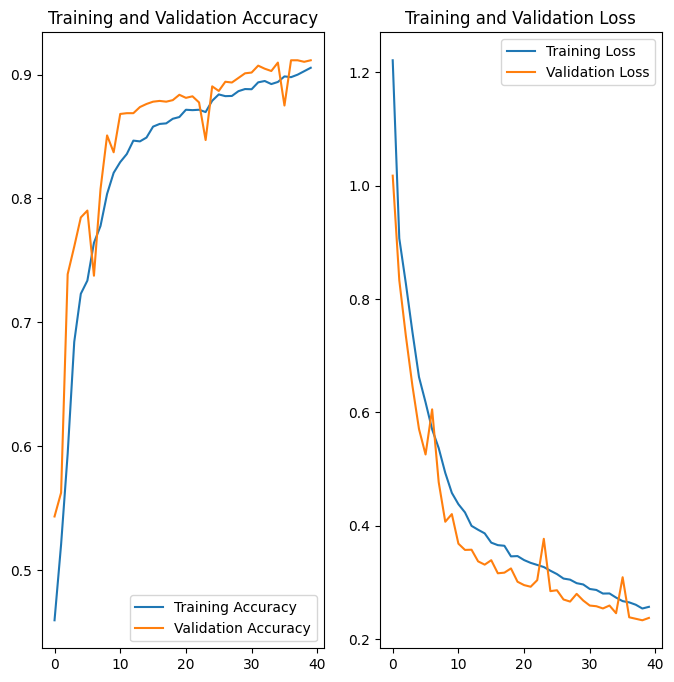

In [121]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [122]:
                                                                                # Step 1
modelGo.load_weights(model_file)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

26/26 [==============================] - 1s 23ms/step
Prediction completes.


In [123]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 91.15%
                 precision    recall  f1-score   support

       arrowana     0.7269    0.8693    0.7918       199
     betta_fish     0.8125    0.8571    0.8342       182
common_goldfish     0.9827    0.9942    0.9884       342
         luohan     0.8011    0.6558    0.7212       215
         oranda     0.9985    0.9779    0.9881       678

       accuracy                         0.9115      1616
      macro avg     0.8643    0.8709    0.8647      1616
   weighted avg     0.9145    0.9115    0.9111      1616



In [124]:
# make predictions

predict_new_image("validate/Screenshot 2022-09-08 210113.jpg")
predict_new_image("validate/0221faa8b79c4b2eb4dfee6f46912d74.jpg")
predict_new_image("validate/word-image.jpeg")


1/1 [==============================] - 0s 61ms/step
[0. 0. 1. 0. 0.]
This image most likely belongs to common_goldfish with a 40.46 percent confidence.
1/1 [==============================] - 0s 15ms/step
[0. 1. 0. 0. 0.]
This image most likely belongs to betta_fish with a 40.46 percent confidence.
1/1 [==============================] - 0s 16ms/step
[0. 0. 0. 1. 0.]
This image most likely belongs to luohan with a 40.46 percent confidence.
